In [60]:
import pandas as pd
import numpy as np
from scipy import stats
import statsmodels.api as sm

df = pd.read_csv('/Users/emilyedgars/Downloads/df_conjoint.csv')

In [61]:
df.head()

#Removing the unnamed column
df = df.drop('Unnamed: 0', axis=1)

In [62]:
#Checking for Missing Data
df.isnull().sum()

excitement_lvl    0
intensity_lvl     0
nausea_lvl        0
max_speed         0
amt_time          0
num_drops         0
high_drop         0
dtype: int64

In [63]:
#Checking for outliers and removing them
Q1 = df['excitement_lvl'].quantile(0.25)
Q3 = df['excitement_lvl'].quantile(0.75)
IQR = Q3 - Q1
outliers = ((df['excitement_lvl'] < (Q1 - 1.5 * IQR)) | (df['excitement_lvl'] > (Q3 + 1.5 * IQR)))

lower_bound = Q1 - 1.5 * IQR
upper_bound = Q3 + 1.5 * IQR

outlier_indices = (df['excitement_lvl'] < lower_bound) | (df['excitement_lvl'] > upper_bound)

num_outliers = sum(outlier_indices)

print(f"Number of outliers: {num_outliers}")

cleaned_df = df[~outliers]

Number of outliers: 6


In [64]:
#Defining Variables and creating dummies for categorical variables
y = cleaned_df['excitement_lvl']
x = cleaned_df[[x for x in df.columns if x != 'excitement_lvl' ]]

In [65]:
xdum = pd.get_dummies(x, columns=[c for c in x.columns if c != 'excitement_lvl'], dtype=int)
xdum.head(10)

,intensity_lvl_High,intensity_lvl_Medium,intensity_lvl_Very High,nausea_lvl_High,nausea_lvl_Low,nausea_lvl_Medium,max_speed_High,max_speed_Low,max_speed_Medium,amt_time_ Very High,amt_time_High,amt_time_Low,amt_time_Medium,num_drops_High,num_drops_Low,num_drops_Medium,high_drop_Low,high_drop_Medium,high_drop_Very High
0,1,0,0,0,0,1,0,1,0,0,0,0,1,0,1,0,1,0,0
1,1,0,0,0,0,1,0,1,0,0,0,0,1,0,1,0,1,0,0
2,0,0,1,0,0,1,0,1,0,0,0,0,1,1,0,0,1,0,0
3,0,0,1,0,0,1,0,1,0,0,1,0,0,0,0,1,0,1,0
4,1,0,0,0,0,1,0,1,0,0,0,0,1,0,1,0,1,0,0
5,1,0,0,0,0,1,0,1,0,0,0,0,1,0,0,1,1,0,0
6,1,0,0,0,0,1,0,1,0,0,0,0,1,0,1,0,0,1,0
7,0,0,1,0,0,1,0,1,0,0,0,0,1,0,0,1,1,0,0
8,0,0,1,1,0,0,0,1,0,0,0,0,1,0,1,0,1,0,0
9,1,0,0,0,0,1,0,1,0,0,0,0,1,0,1,0,1,0,0


In [67]:
import statsmodels.api as sm
import seaborn as sns
import matplotlib.pyplot as plt
plt.style.use('bmh')

#As our dependent variable is numerical, we're using Ordinary Least Squares regression, rather than logistic regression
# y: Numerical dependent variable.
# xdum: Design matrix with dummy variables.

In [68]:
ols_model = sm.OLS(y, xdum)
res = ols_model.fit()

print(result.summary())

                            OLS Regression Results                            
Dep. Variable:         excitement_lvl   R-squared:                       0.521
Model:                            OLS   Adj. R-squared:                  0.420
Method:                 Least Squares   F-statistic:                     5.180
Date:                Fri, 29 Dec 2023   Prob (F-statistic):           3.91e-06
Time:                        23:38:43   Log-Likelihood:                -104.51
No. Observations:                  76   AIC:                             237.0
Df Residuals:                      62   BIC:                             269.6
Df Model:                          13                                         
Covariance Type:            nonrobust                                         
                              coef    std err          t      P>|t|      [0.025      0.975]
-------------------------------------------------------------------------------------------
intensity_lvl_High        

F-statistic: 5.180
The F-statistic tests the overall significance of the model. The associated probability (Prob (F-statistic)) is 3.91e-06, indicating that at least one of the independent variables is significantly related to the dependent variable.

R-squared: 0.521
R-squared represents the proportion of variance in the dependent variable explained by the independent variables. In this case, approximately 52.1% of the variability in excitement_lvl is explained by the model.
Adj. R-squared: 0.420, they're close which shows an adequate model

For the predictor "intensity_lvl_High," the coefficient is 1.6206.
The p-value is less than 0.05 (P>|t| < 0.05), indicating that this predictor is statistically significant.
The coefficient suggests that, holding other variables constant, an increase of one unit in "intensity_lvl_High" is associated with an increase of approximately 1.6206 units in excitement_lvl.

Assumptions: Testing for Autocorrelation in the residuals
The Durbin-Watson statistic is reported as 1.890. A value close to 2 suggests no significant autocorrelation in the residuals.

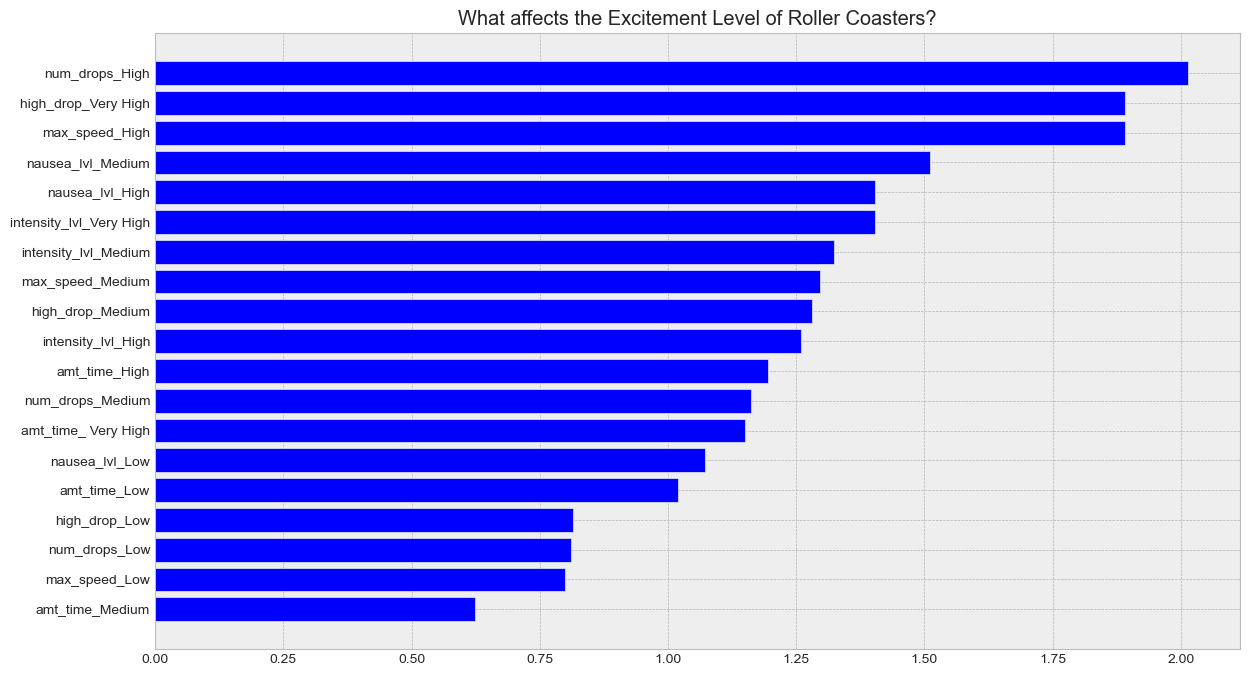

In [69]:
df_res = pd.DataFrame({
    'param_name': res.params.keys()
    , 'param_w': res.params.values
    , 'pval': res.pvalues
})
# adding field for absolute of parameters
df_res['abs_param_w'] = np.abs(df_res['param_w'])
# marking field is significant under 95% confidence interval
df_res['is_sig_95'] = (df_res['pval'] < 0.05)
# constructing color naming for each param
df_res['c'] = ['blue' if x else 'red' for x in df_res['is_sig_95']]

# make it sorted by abs of parameter value
df_res = df_res.sort_values(by='abs_param_w', ascending=True)

f, ax = plt.subplots(figsize=(14, 8))
plt.title('What affects the Excitement Level of Roller Coasters?')
pwu = df_res['param_w']
xbar = np.arange(len(pwu))
plt.barh(xbar, pwu, color=df_res['c'])
plt.yticks(xbar, labels=df_res['param_name'])
plt.show()

The parameters that are indicated with blue are significant and the parameters that are indicated red are not.

Creating a graph with the importance of each coefficient for comprehensible insights.

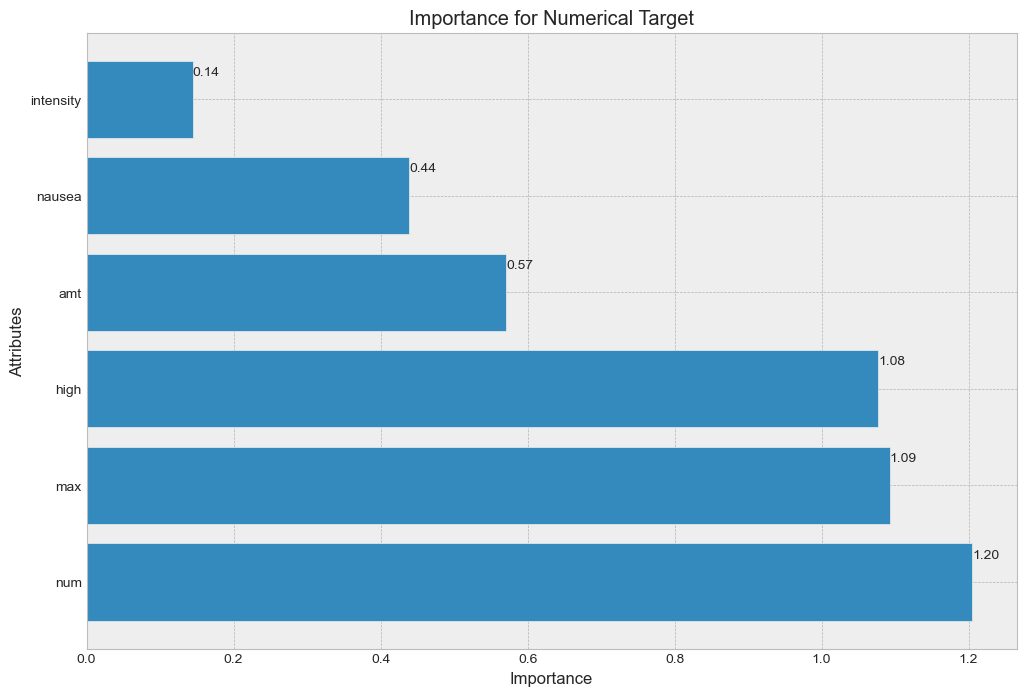

In [70]:
# Create a dictionary to store the range of coefficients for each feature
range_per_feature = dict()

# Iterate through each parameter in the regression results
for key, coeff in res.params.items():
    sk = key.split('_')
    feature = sk[0]
    if len(sk) == 1:
        feature = key
    if feature not in range_per_feature:
        range_per_feature[feature] = list()

    range_per_feature[feature].append(coeff)

# Calculate the importance per feature as the range of coefficients for that feature
importance_per_feature = {
    k: max(v) - min(v) for k, v in range_per_feature.items()
}

# Create a DataFrame for visualization
alt_data = pd.DataFrame(
    list(importance_per_feature.items()),
    columns=['attr', 'importance']
).sort_values(by='importance', ascending=False)

# Create a horizontal bar plot to visualize the importance of each feature
f, ax = plt.subplots(figsize=(12, 8))
xbar = np.arange(len(alt_data['attr']))
plt.title('Importance for Numerical Target')
plt.barh(xbar, alt_data['importance'])
for i, v in enumerate(alt_data['importance']):
    ax.text(v, i + .25, '{:.2f}'.format(v))
plt.ylabel('Attributes')
plt.xlabel('Importance')

# Set the y-axis ticks with full variable names
plt.yticks(xbar, alt_data['attr'])

plt.show()

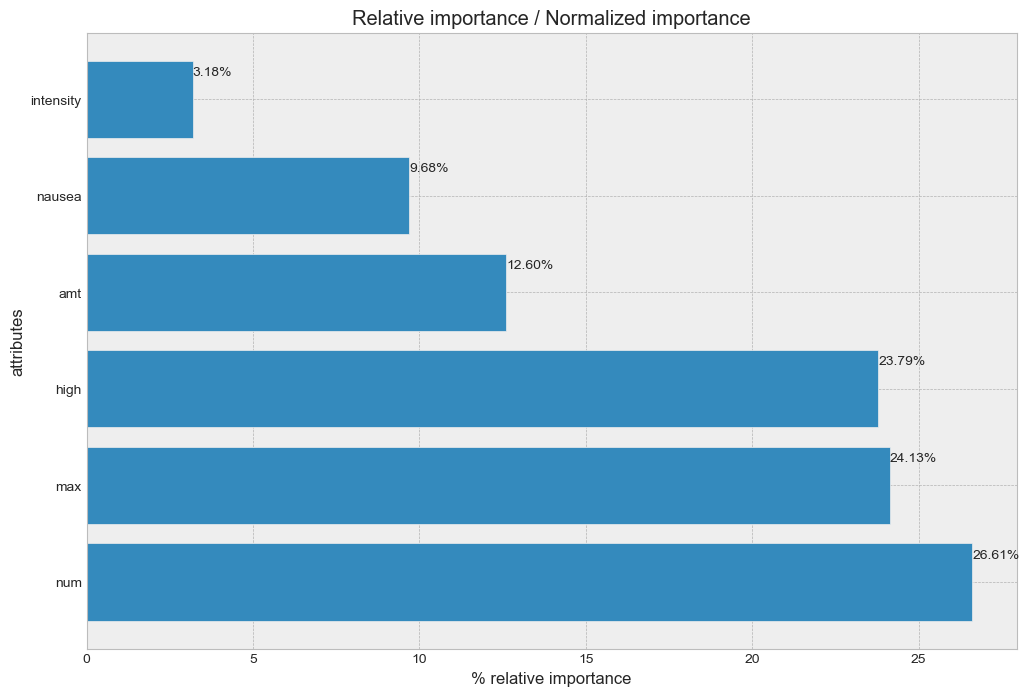

In [71]:
# Calculate the total range of coefficients
total_range = sum(importance_per_feature.values())

# Calculate the relative importance of each feature
relative_importance_per_feature = {k: (v / total_range) * 100 for k, v in importance_per_feature.items()}

alt_data = pd.DataFrame(
    list(relative_importance_per_feature.items()),
    columns=['attr', 'relative_importance (pct)']
).sort_values(by='relative_importance (pct)', ascending=False)


f, ax = plt.subplots(figsize=(12, 8))
xbar = np.arange(len(alt_data['attr']))
plt.title('Relative importance / Normalized importance')
plt.barh(xbar, alt_data['relative_importance (pct)'])
for i, v in enumerate(alt_data['relative_importance (pct)']):
    ax.text(v , i + .25, '{:.2f}%'.format(v))
plt.ylabel('attributes')
plt.xlabel('% relative importance')
plt.yticks(xbar, alt_data['attr'])
plt.show()